In [206]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

# Data loading

## Movie data

In [77]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


In [78]:
movies.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [79]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


# TO DO

Observed issues: 

The date format is not constant, sometimes it's the year only, sometimes it's yyyy-mm-dd

Box office revenue is not always available: NaN + Should take into account inflation

For language, countries and genres there's a code in addition to the information (can we use it??)

To check : 

Missing values

Outliars: height way too big 

Are their any duplicated when considering number of movies?

Calculate a weighted rating : vote * rating?

### Find data set with budget spent!!!

## Character data

In [80]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
154827,6471903,/m/0g6l1j,1991-04-25,NaN,1930-01-06,M,1.870,NaN,"Charles Kalani, Jr.",61.0,/m/0cv4j1f,NaN,/m/08_0lz
390834,33038356,/m/0h566cd,2011-09-09,Jackie,1974-12-28,F,NaN,NaN,Stephanie Che,36.0,/m/0hzhdcv,/m/0k3cjhh,/m/0bs72y7
130530,21585364,/m/05msnmp,2003,Jerry James,1950-10-01,M,1.943,/m/0fqz6,Randy Quaid,52.0,/m/0csbfb5,/m/0h2vwx8,/m/01w23w
3055,4453753,/m/0c38k8,1991-06-05,NaN,NaN,M,NaN,NaN,Erik Slavin,NaN,/m/0bv9tv2,NaN,/m/0bv9tv0
238291,21249583,/m/05b_c66,2008-10-02,Sabyasachi Misra,NaN,M,NaN,NaN,Sabyasachi Misra,NaN,/m/0k14mzv,/m/0k14mzy,/m/0k103r2


freebase_character_actor_map_id ?
movies are referred to by wikipedia id or freebase id
lots of data missing especially for: ethnicity, charcter name (maybe some characters aren't named in movies) , 
different date formats for release date 

## IMDB data

In [81]:
imdb_top_1000 = pd.read_csv('data/imdb/imdb_top_1000.csv', thousands=',')

In [82]:
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


In [83]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [84]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
3381,Suspiria,2018,6.8,R,152,"Fantasy, Horror, Mystery","Oct 12, 2018",20000000,2483472,7023292
689,Space Jam,1996,6.4,PG,88,"Animation, Adventure, Comedy","Nov 15, 1996",80000000,90463534,250180384
366,21 Jump Street,2012,7.2,R,109,"Action, Comedy, Crime","Mar 14, 2012",42000000,138447667,202812429
975,Dante's Peak,1997,5.9,PG-13,108,"Action, Adventure, Thriller","Feb 7, 1997",115000000,67163857,178200000
1674,"Big Mommas: Like Father, Like Son",2011,4.4,PG-13,107,"Action, Comedy, Crime","Feb 18, 2011",32000000,37915414,82332450


### Wikipedia

In [183]:
wikipedia_pageviews = pd.read_csv('./handled_data/movies_wikipedia_pageviews.csv')

# Cleaning & Pre-processing of data

In [85]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [86]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [87]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [88]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [89]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [90]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [91]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [92]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [93]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [94]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [95]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [96]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [97]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [98]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

Add ethnicity labels using the freebase ethnicity ids

In [99]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv', index_col=0)

In [100]:
def get_actor_ethnicity_label(row):
    try:
        ethnicity_label = ethnicity_freebase_ids.loc[row['actor_ethnicity_freebase_id'], 'ethnicity_label']
    except:
        ethnicity_label = np.NaN
    return ethnicity_label


In [101]:
characters['actor_ethnicity'] = characters.apply(lambda row: get_actor_ethnicity_label(row),axis=1)

In [102]:
characters

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,actor_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,unknown
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,English people
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


In [103]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154809.000000,292175.000000
mean,1.396975e+07,1.748177,37.890901
std,1.079662e+07,0.106249,14.085909
min,3.300000e+02,0.610000,0.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [104]:
imdb_top_1000['Runtime'].str.contains(r'\d+ min').value_counts()

True    1000
Name: Runtime, dtype: int64

In [105]:
imdb_top_1000['Runtime'] = imdb_top_1000['Runtime'].str.extract(r'(\d+) min', expand=False).astype(int)
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


In [106]:
imdb_top_1000.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,1000.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02
mean,122.891000,7.949300,77.971530,2.736929e+05,6.803475e+07
std,28.093671,0.275491,12.376099,3.273727e+05,1.097500e+08
min,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,103.000000,7.700000,70.000000,5.552625e+04,3.253559e+06
50%,119.000000,7.900000,79.000000,1.385485e+05,2.353089e+07
75%,137.000000,8.100000,87.000000,3.741612e+05,8.075089e+07
max,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


In [107]:
imdb_top_1000.dtypes

Poster_Link       object
Series_Title      object
Released_Year     object
Certificate       object
Runtime            int64
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross            float64
dtype: object

To estimate a movie success, we need to both account for the rating 'IMDB_Rating' and to the correponding number of votes 'No_of_Votes'. To do so, we build a new weighted rating based on a shrinkage estimator: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

[Text(0.5, 1.0, 'Distribution of IMDB ratings'),
 Text(0.5, 0, 'IMDB rating'),
 Text(0, 0.5, 'Number of films')]

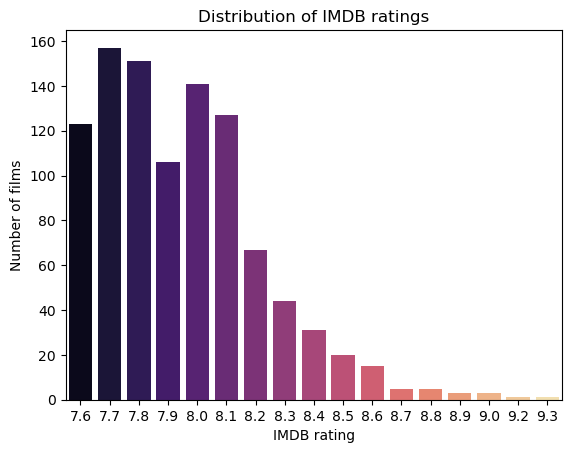

In [108]:
sns.countplot(x='IMDB_Rating', data = imdb_top_1000, palette="magma").set(title='Distribution of IMDB ratings',xlabel='IMDB rating', ylabel='Number of films')


[Text(0.5, 1.0, 'Distribution of IMDB ratings'),
 Text(0.5, 0, 'IMDB rating'),
 Text(0, 0.5, 'Number of films')]

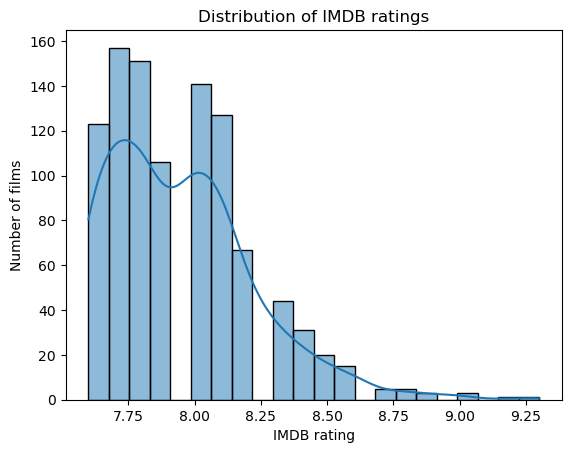

In [109]:
sns.histplot(x='IMDB_Rating', data = imdb_top_1000, kde=True).set(title='Distribution of IMDB ratings',xlabel='IMDB rating', ylabel='Number of films')


In [110]:
C = imdb_top_1000['IMDB_Rating'].mean()
m = 25000#imdb_top_1000['No_of_Votes'].min()
v = imdb_top_1000['No_of_Votes']
R = imdb_top_1000['IMDB_Rating']

In [111]:
imdb_top_1000['WR'] = (v / (v + m)) * R + (m / (v + m)) * C


To check if the weighted rating has worked, we display below the best rated movie. We observe that for an IMDB rating of 9/10, the weighted rating WR is better for movies with the most votes. We conclude that this weighted rating is more representative of a movie' success.

In [112]:
imdb_top_1000[['Series_Title','IMDB_Rating','WR','No_of_Votes']].sort_values('WR', ascending=False).head()

,Series_Title,IMDB_Rating,WR,No_of_Votes
0,The Shawshank Redemption,9.3,9.285741,2343110
1,The Godfather,9.2,9.180997,1620367
2,The Dark Knight,9.0,8.988718,2303232
3,The Godfather: Part II,9.0,8.977257,1129952
4,12 Angry Men,9.0,8.963254,689845


TEST : ISSUE HERE

In [113]:
imdb_top_1000[['Series_Title','IMDB_Rating','WR','No_of_Votes']].sort_values('WR', ascending=True).head()

,Series_Title,IMDB_Rating,WR,No_of_Votes
928,300,7.6,7.611522,732876
947,Harry Potter and the Sorcerer's Stone,7.6,7.612782,658185
914,Sherlock Holmes,7.6,7.614359,583158
887,Guardians of the Galaxy Vol. 2,7.6,7.614677,569974
879,Once Upon a Time... in Hollywood,7.6,7.615152,551309


[Text(0.5, 1.0, 'Distribution of weighted ratings on IMDB database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

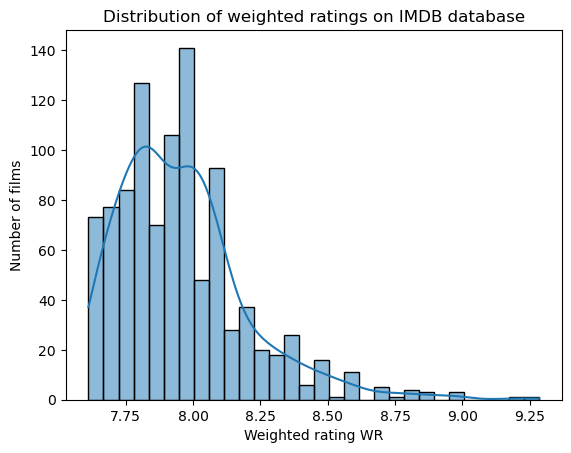

In [114]:
sns.histplot(x='WR', data = imdb_top_1000, kde=True).set(title='Distribution of weighted ratings on IMDB database',xlabel='Weighted rating WR', ylabel='Number of films')


### Merge IMDB database with movie database to have common features

In [115]:
movie_feature = imdb_top_1000.merge(movies, left_on='Series_Title', right_on='name',how='inner')

In [116]:
print(f'There are {movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb_top_1000.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


There are 875 common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes 1000 elements and Movie corpus includes 81741.


In [117]:
movie_feature.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

[Text(0.5, 1.0, 'Distribution of weighted ratings on merged database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

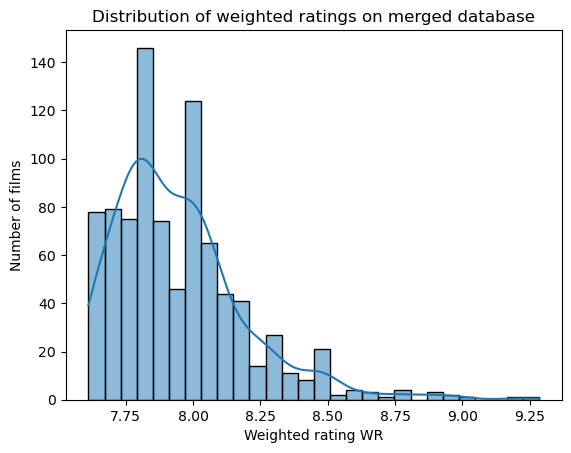

In [118]:
sns.histplot(x='WR', data = movie_feature, kde=True).set(title='Distribution of weighted ratings on merged database',xlabel='Weighted rating WR', ylabel='Number of films')


### Fill missing budget data from imdb budget dataset

In [119]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
2237,Raging Bull,1980,8.2,R,129,"Biography, Drama, Sport","Nov 14, 1980",18000000,23380203,23380203
1412,Red Sparrow,2018,6.6,R,140,"Action, Drama, Thriller","Feb 28, 2018",69000000,46874505,145951861
1568,Clash of the Titans,1981,6.9,PG,118,"Action, Adventure, Family","Jun 12, 1981",15000000,30000000,44400000
389,Grown Ups 2,2013,5.4,PG-13,101,Comedy,"Jul 12, 2013",80000000,133668525,247023808
2803,Lone Wolf McQuade,1983,6.4,PG,107,"Action, Crime, Drama","Apr 15, 1983",5000000,12232628,12232628


In [120]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


In [121]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date


In [122]:
#list(movie_feature['release_year'].unique())

In [123]:
#movie_feature['release_year'] = movie_feature['release_year'].replace('nan', np.nan).astype('Int16')
#movie_feature['release_month'] = movie_feature['release_month'].replace('nan', np.nan).astype('Int16')
#movie_feature['release_day'] = movie_feature['release_day'].replace('nan', np.nan).astype('Int16')

In [124]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('Int16')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('Int16')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('Int16')

In [125]:
imdb_budget.drop(['Year', 'IMDb', 'Rating', 'Runtime', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'genres', 'Production Budget', 'Domestic Gross',
       'Worldwide Gross', 'release_year', 'release_month', 'release_day'],
      dtype='object')

In [126]:
imdb_budget.describe()

,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3.828000e+03,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000
mean,4.030960e+07,5.559021e+07,1.206910e+08,2003.594044,7.322100,15.891066
std,4.480927e+07,7.403263e+07,1.993646e+08,12.767740,3.378479,8.437532
min,7.000000e+03,0.000000e+00,0.000000e+00,1925.000000,1.000000,1.000000
25%,1.100000e+07,1.180967e+07,1.690363e+07,1999.000000,5.000000,9.000000
50%,2.500000e+07,3.225471e+07,5.077617e+07,2006.000000,8.000000,16.000000
75%,5.000000e+07,6.848642e+07,1.388776e+08,2013.000000,10.000000,23.000000
max,4.000000e+08,8.583730e+08,2.797801e+09,2020.000000,12.000000,31.000000


In [127]:
movie_feature.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime
count,875.000000,875.000000,763.000000,8.750000e+02,7.400000e+02,875.000000,8.750000e+02,5.240000e+02,818.000000
mean,124.666286,7.934171,78.474443,2.946588e+05,7.572251e+07,7.946176,7.492496e+06,1.398682e+08,118.013203
std,32.490318,0.275648,12.559687,3.380820e+05,1.095308e+08,0.245953,1.026922e+07,2.506817e+08,35.676872
min,64.000000,7.600000,28.000000,2.593800e+04,3.296000e+03,7.611522,3.746000e+03,1.047400e+04,2.000000
25%,102.000000,7.700000,71.000000,6.353300e+04,6.190768e+06,7.771961,1.715650e+05,1.199760e+07,96.000000
50%,120.000000,7.900000,79.000000,1.598860e+05,3.530697e+07,7.908253,1.673949e+06,5.111259e+07,114.000000
75%,138.000000,8.100000,88.000000,4.059220e+05,1.004922e+08,8.064510,1.245293e+07,1.358420e+08,133.000000
max,321.000000,9.300000,100.000000,2.343110e+06,7.605076e+08,9.285741,3.692924e+07,2.782275e+09,360.000000


In [128]:
imdb_budget['genres'] = imdb_budget['genres'].apply(lambda x: x.split(', '))

In [129]:
movie_feature.update(imdb_budget)

In [130]:
movie_feature['release_year'] = movie_feature['release_year'].astype('Int16')
movie_feature['release_month'] = movie_feature['release_month'].astype('Int16')
movie_feature['release_day'] = movie_feature['release_day'].astype('Int16')

In [131]:
movie_feature.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day
count,875.000000,875.000000,763.000000,8.750000e+02,7.400000e+02,875.000000,8.750000e+02,5.240000e+02,818.000000,875.000000,875.000000,875.000000
mean,124.666286,7.934171,78.474443,2.946588e+05,7.572251e+07,7.946176,7.492496e+06,1.398682e+08,118.013203,2004.691429,7.432000,15.966857
std,32.490318,0.275648,12.559687,3.380820e+05,1.095308e+08,0.245953,1.026922e+07,2.506817e+08,35.676872,11.834803,3.243142,8.340030
min,64.000000,7.600000,28.000000,2.593800e+04,3.296000e+03,7.611522,3.746000e+03,1.047400e+04,2.000000,1937.000000,1.000000,1.000000
25%,102.000000,7.700000,71.000000,6.353300e+04,6.190768e+06,7.771961,1.715650e+05,1.199760e+07,96.000000,2000.000000,5.000000,9.000000
50%,120.000000,7.900000,79.000000,1.598860e+05,3.530697e+07,7.908253,1.673949e+06,5.111259e+07,114.000000,2007.000000,7.000000,16.000000
75%,138.000000,8.100000,88.000000,4.059220e+05,1.004922e+08,8.064510,1.245293e+07,1.358420e+08,133.000000,2013.000000,11.000000,23.000000
max,321.000000,9.300000,100.000000,2.343110e+06,7.605076e+08,9.285741,3.692924e+07,2.782275e+09,360.000000,2020.000000,12.000000,31.000000


In [132]:
imdb_budget.drop(['release_year', 'release_month', 'release_day', 'genres'], axis=1, inplace=True)

In [133]:
movie_feature_with_budget = pd.merge(movie_feature, imdb_budget, on='name',  how='left')

In [134]:
movie_feature_with_budget.sample(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,runtime,languages,countries,genres,release_year,release_month,release_day,Production Budget,Domestic Gross,Worldwide Gross
113,https://m.media-amazon.com/images/M/MV5BMTY1Nz...,Bhaag Milkha Bhaag,2013,U,186,"Biography, Drama, Sport",8.2,The truth behind the ascension of Milkha Singh...,NaN,Rakeysh Omprakash Mehra,...,NaN,[Hindi],[India],"[Action, Adventure]",1981,6,12,20000000,225686079,367452079
368,https://m.media-amazon.com/images/M/MV5BOTA1Mj...,Touch of Evil,1958,PG-13,95,"Crime, Drama, Film-Noir",8.0,"A stark, perverse story of murder, kidnapping,...",99.0,Orson Welles,...,111.0,"[English, Spanish]",[United States of America],"[Animation, Action, Adventure]",2016,1,23,140000000,143528619,521170825
46,https://m.media-amazon.com/images/M/MV5BZmU0M2...,Back to the Future,1985,U,116,"Adventure, Comedy, Sci-Fi",8.5,"Marty McFly, a 17-year-old high school student...",87.0,Robert Zemeckis,...,116.0,[English],[United States of America],"[Action, Adventure, Thriller]",2015,4,1,190000000,353007020,1518722794
781,https://m.media-amazon.com/images/M/MV5BMzYyNz...,The Magnificent Seven,1960,Approved,128,"Action, Adventure, Western",7.7,Seven gunfighters are hired by Mexican peasant...,74.0,John Sturges,...,128.0,"[English, Spanish]",[United States of America],"[Animation, Adventure, Comedy]",2014,11,26,132000000,83350911,366942531
261,https://m.media-amazon.com/images/M/MV5BYjE2OT...,The Third Man,1949,Approved,104,"Film-Noir, Mystery, Thriller",8.1,Pulp novelist Holly Martins travels to shadowy...,97.0,Carol Reed,...,93.0,"[English, Russian, German]","[England, United Kingdom]","[Adventure, Drama, History]",1995,6,30,65000000,173772767,335802271


In [135]:
movie_feature_with_budget['profit'] = movie_feature_with_budget['Worldwide Gross'] - movie_feature_with_budget['Production Budget']

In [136]:
movie_feature_with_budget.describe()

# original : box office revenue : 552 movies 
# IMDB  : gross revenue : 774 movies 
# IMDB dataset with budget spent : budget, domestic gross, worldwide gross : 915 movies 



,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day,Production Budget,Domestic Gross,Worldwide Gross,profit
count,915.000000,915.000000,802.000000,9.150000e+02,7.740000e+02,915.000000,9.150000e+02,5.520000e+02,855.000000,915.000000,915.000000,915.000000,9.150000e+02,9.150000e+02,9.150000e+02,9.150000e+02
mean,124.730055,7.939126,78.523691,3.021651e+05,7.623901e+07,7.950764,7.402548e+06,1.430743e+08,118.171696,2004.548634,7.408743,15.864481,8.191084e+07,1.549634e+08,3.609426e+08,2.790317e+08
std,32.449495,0.279299,12.428475,3.491507e+05,1.091009e+08,0.250094,1.023047e+07,2.509449e+08,35.388353,12.179663,3.239717,8.307756,6.271666e+07,9.880299e+07,3.007794e+08,2.637485e+08
min,64.000000,7.600000,28.000000,2.593800e+04,3.296000e+03,7.611522,3.746000e+03,1.047400e+04,2.000000,1937.000000,1.000000,1.000000,3.250000e+05,8.817450e+05,8.817450e+05,-2.411826e+07
25%,102.000000,7.700000,71.000000,6.356000e+04,6.290794e+06,7.773736,1.673350e+05,1.221116e+07,96.000000,1999.000000,5.000000,9.000000,3.200000e+07,9.257084e+07,1.761823e+08,1.220421e+08
50%,120.000000,7.900000,79.000000,1.644620e+05,3.564609e+07,7.909029,1.643298e+06,5.183651e+07,114.000000,2007.000000,7.000000,16.000000,6.800000e+07,1.250140e+08,2.668243e+08,1.941042e+08
75%,138.000000,8.100000,88.000000,4.171780e+05,1.009911e+08,8.074705,1.225605e+07,1.479548e+08,133.000000,2013.000000,11.000000,23.000000,1.200000e+08,1.799474e+08,4.328521e+08,3.416571e+08
max,321.000000,9.300000,100.000000,2.343110e+06,7.605076e+08,9.285741,3.692924e+07,2.782275e+09,360.000000,2020.000000,12.000000,31.000000,4.000000e+08,8.583730e+08,2.797801e+09,2.551701e+09


## Account for inflation: 

Source: https://inflationdata.com/Inflation/Inflation/DecadeInflation.asp

In [137]:
# Create dictionary of cumulative inflation rate per decade since 1913 in the US:
inflation_rates = [92.86, 4.82, -18.6, 68.57, 24.58, 28.23, 103.45, 64.41, 33.47, 28.31, 19.38, 1.27]
inflation_rates = [x / 100 + 1 for x in inflation_rates]
decades = list(np.linspace(1913,2023,len(inflation_rates)))
inflation_dic = dict(map(lambda i,j : (i,j) , decades, inflation_rates))

In [138]:
df = movie_feature_with_budget.copy()

In [139]:
# Initialisation
df['profit_modified'] = df['profit']
df['box_office_revenue_modified'] = df['box_office_revenue']
df['Domestic Gross_modified'] = df['Domestic Gross']
df['Worldwide Gross_modified'] = df['Worldwide Gross']
df['Gross_modified'] = df['Gross']

In [140]:
for k in range(len(decades)-1): # For each decade
    year_before = decades[k]
    year = decades[k+1]
    inflation_rate = inflation_dic[year_before]
    
    decade_df = df[(df['release_year']<year) & (df['release_year']>year_before)] # decade mask
    
    idx = decade_df.index.tolist()

    # Create new column with prices modified by interest rate
    df.loc[idx, 'profit_modified'] = decade_df['profit'] * inflation_rate
    df.loc[idx, 'box_office_revenue_modified'] = decade_df['box_office_revenue'] * inflation_rate
    df.loc[idx, 'Domestic Gross'] = decade_df['Domestic Gross'] * inflation_rate
    df.loc[idx, 'Worldwide Gross_modified'] = decade_df['Worldwide Gross'] * inflation_rate
    df.loc[idx, 'Gross_modified'] = decade_df['Gross'] * inflation_rate
   

In [141]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,release_day,Production Budget,Domestic Gross,Worldwide Gross,profit,profit_modified,box_office_revenue_modified,Domestic Gross_modified,Worldwide Gross_modified,Gross_modified
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,...,23,400000000,1.024726e+09,2797800564,2397800564,2.862494e+09,3.383405e+07,858373000,3.340014e+09,3.383405e+07
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,...,17,237000000,9.758073e+08,2788701337,2551701337,3.274088e+09,3.445124e+08,760507625,3.578183e+09,1.731754e+08
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,...,13,200000000,8.357311e+08,1346103376,1146103376,1.368218e+09,1.199242e+09,700059566,1.606978e+09,6.385140e+08
3,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,...,25,300000000,8.103699e+08,2048359754,1748359754,2.087192e+09,NaN,678815482,2.445332e+09,5.204968e+06
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,...,18,200000000,8.800531e+08,2208208395,2008208395,2.680356e+09,1.334700e+06,659363944,2.947296e+09,5.819292e+06


### Wikipedia pageviews

In [187]:
wikipedia_pageviews['date'] = pd.to_datetime(wikipedia_pageviews['date'], format='%Y%m%d%H')

In [188]:
wikipedia_pageviews.sample(5)

,movie_name,date,pageviews
1454886,Driving Miss Daisy,2016-09-13,1265
1615786,A Wrinkle in Time,2016-09-15,5994
1107315,Sweet Home Alabama,2015-09-23,944
1353846,The Pacifier,2017-12-26,1140
646817,National Treasure,2022-05-15,3


In [189]:
wikipedia_pageviews.describe()

,pageviews
count,2.301748e+06
mean,1.688527e+03
std,6.576590e+03
min,0.000000e+00
25%,1.170000e+02
50%,8.810000e+02
75%,1.891000e+03
max,1.982874e+06


In [196]:
wikipedia_pageviews.rename({'movie_name': 'name'}, axis=1, inplace=True)

In [204]:
wikipedia_pageviews_mean_per_day = wikipedia_pageviews.groupby('name').mean()
movie_feature_with_budget_and_wikipedia_pageviews = pd.merge(movie_feature_with_budget, wikipedia_pageviews_mean_per_day, on='name', how='left')

In [205]:
movie_feature_with_budget_and_wikipedia_pageviews.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day,Production Budget,Domestic Gross,Worldwide Gross,profit,genre1_category,pageviews
count,915.000000,915.000000,802.000000,9.150000e+02,7.740000e+02,915.000000,9.150000e+02,5.520000e+02,855.000000,915.000000,915.000000,915.000000,9.150000e+02,9.150000e+02,9.150000e+02,9.150000e+02,915.000000,915.000000
mean,124.730055,7.939126,78.523691,3.021651e+05,7.623901e+07,7.950764,7.402548e+06,1.430743e+08,118.171696,2004.548634,7.408743,15.864481,8.191084e+07,1.549634e+08,3.609426e+08,2.790317e+08,2.384699,1803.256002
std,32.449495,0.279299,12.428475,3.491507e+05,1.091009e+08,0.250094,1.023047e+07,2.509449e+08,35.388353,12.179663,3.239717,8.307756,6.271666e+07,9.880299e+07,3.007794e+08,2.637485e+08,2.487295,2449.409856
min,64.000000,7.600000,28.000000,2.593800e+04,3.296000e+03,7.611522,3.746000e+03,1.047400e+04,2.000000,1937.000000,1.000000,1.000000,3.250000e+05,8.817450e+05,8.817450e+05,-2.411826e+07,0.000000,0.833333
25%,102.000000,7.700000,71.000000,6.356000e+04,6.290794e+06,7.773736,1.673350e+05,1.221116e+07,96.000000,1999.000000,5.000000,9.000000,3.200000e+07,9.257084e+07,1.761823e+08,1.220421e+08,0.000000,175.371243
50%,120.000000,7.900000,79.000000,1.644620e+05,3.564609e+07,7.909029,1.643298e+06,5.183651e+07,114.000000,2007.000000,7.000000,16.000000,6.800000e+07,1.250140e+08,2.668243e+08,1.941042e+08,2.000000,1133.846382
75%,138.000000,8.100000,88.000000,4.171780e+05,1.009911e+08,8.074705,1.225605e+07,1.479548e+08,133.000000,2013.000000,11.000000,23.000000,1.200000e+08,1.799474e+08,4.328521e+08,3.416571e+08,4.000000,2290.426902
max,321.000000,9.300000,100.000000,2.343110e+06,7.605076e+08,9.285741,3.692924e+07,2.782275e+09,360.000000,2020.000000,12.000000,31.000000,4.000000e+08,8.583730e+08,2.797801e+09,2.551701e+09,12.000000,37415.568125


# Exploratory Data Analysis

Looking at the impacts of features on eachother by drawing a correlation heatmap

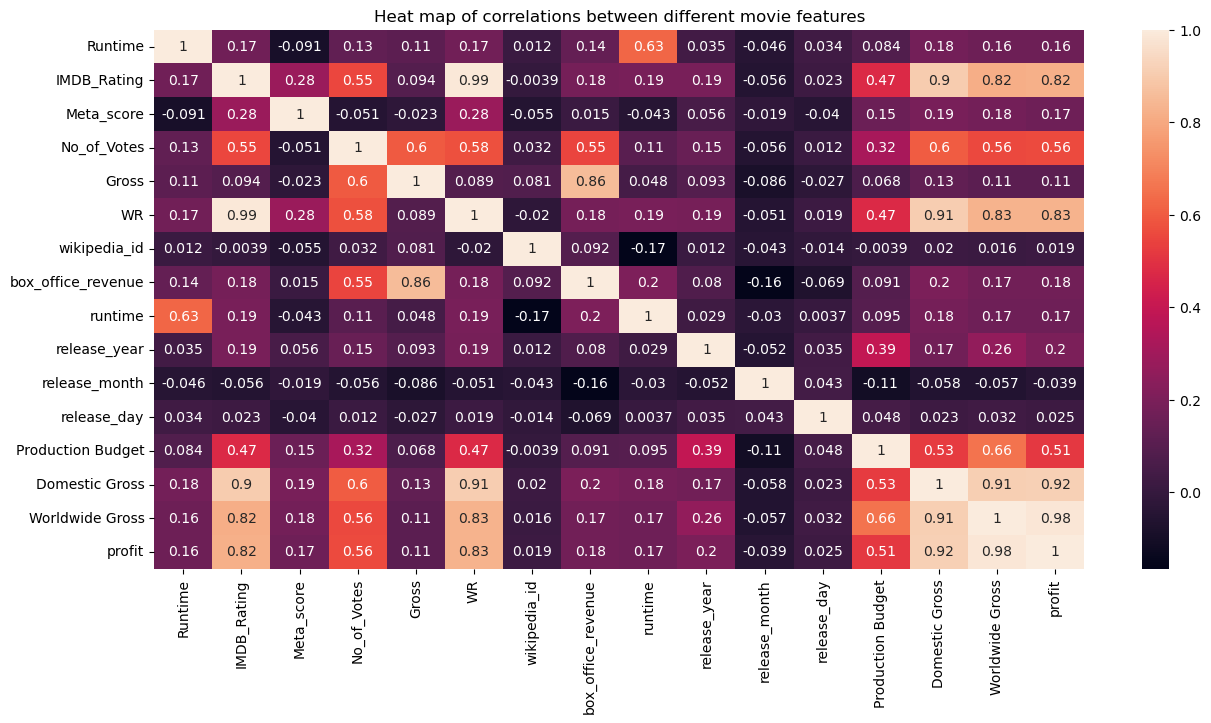

In [142]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(movie_feature_with_budget.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


Success indicators: 

- IMDB rating -> weighted rating : WR 
- gross revenue (15000 types) 
- wikipedia ID connection query : how much a movie lasts in time
- profit = revenue - budget 

1. correlation btw success indicators 
2. Check if we have the same successful movies & actors according to different indicators
3. Succesfulness = function (all indicators) 



Actor success: 
Weight in terms of number of apparearance and movie WR

### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the 'box_office_revenue'. Since 'WR' and 'release_month' are features coming from two different datasets, we need to use the merged dataframe movie_feature which contains only 875. We can then compare the results found with ('WR','release_month') to ('box_office_revenue','release_month') which is based on much more data: 81741. 

-> CAREFUL, WHY ARE RATINGS AND GROSS REVENUE COMPLETELY UNCORRELATED ? 

In [143]:
df_release = movie_feature.dropna(how='all', subset=['release_month']) # Remove NaN months

In [144]:
movies['release_month'].describe()

count     42667
unique       12
top          09
freq       4268
Name: release_month, dtype: object

In [145]:
df_release.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [146]:
df_release=df_release.sort_values(by='release_month', ascending=True)

Text(0.5, 1.0, 'Successfulness of Movie Release By Month')

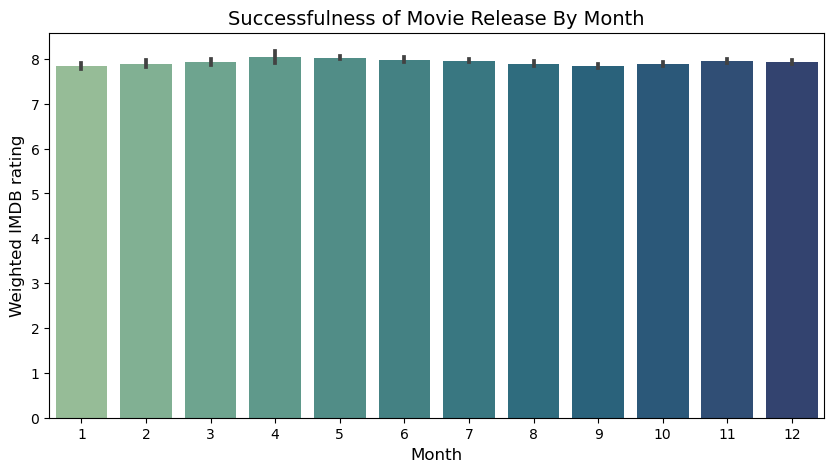

In [147]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="WR",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Successfulness of Movie Release By Month', fontsize=14)

Text(0.5, 1.0, 'Successfulness in terms of box office revenue of Movie Release By Month')

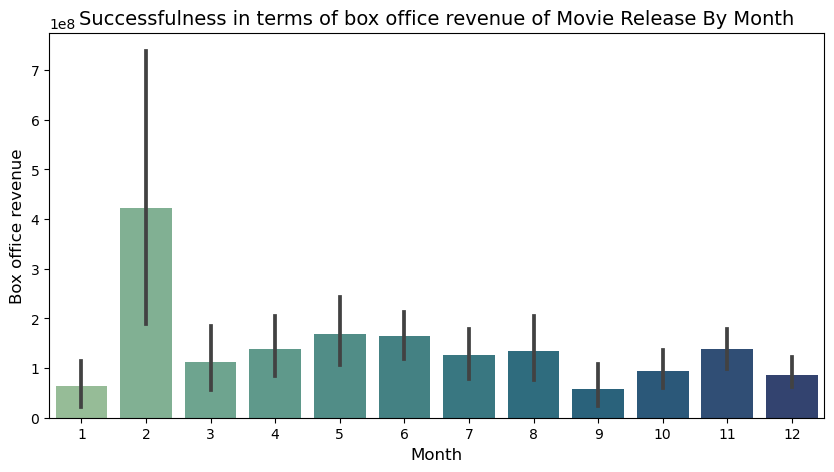

In [148]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="box_office_revenue",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Box office revenue', fontsize=12)
plt.title('Successfulness in terms of box office revenue of Movie Release By Month', fontsize=14)

Text(0.5, 1.0, 'Successfulness in terms of gross revenue of Movie Release By Month')

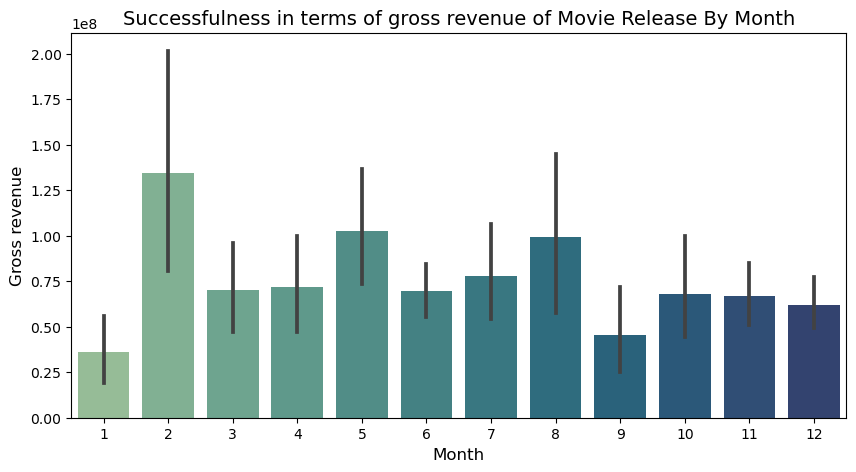

In [149]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="Gross",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Gross revenue', fontsize=12)
plt.title('Successfulness in terms of gross revenue of Movie Release By Month', fontsize=14)

## What budget should be spent on a successful movie?

To see what budget should be spent on a successful movie, we want to compare maintly three features, the budget spent 'Production Budget', the profit made 'profit' and the rating of the movie to account for successfulness.

CHECK FOR SUCCESSFULNESS. 

As our movie database has movies dating back to 1921, we need to adjust the budgets and profits through an inflation rate

In [150]:
movie_feature_with_budget.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day', 'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'profit'],
      dtype='object')

In [151]:
min(movie_feature_with_budget['Released_Year'])

'1921'

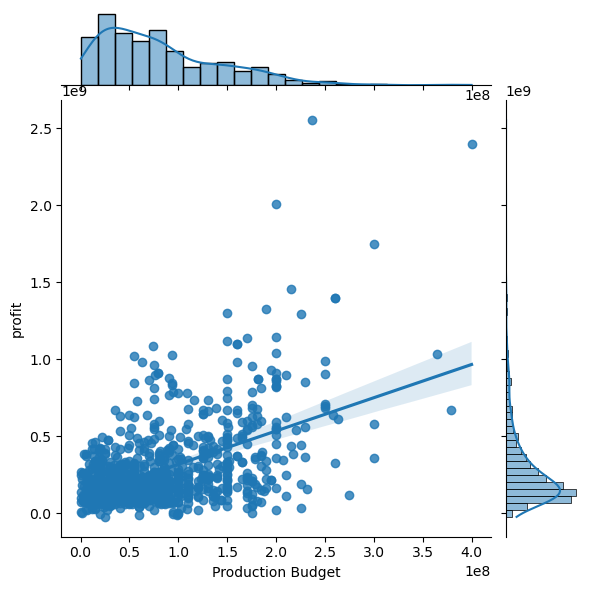

In [152]:
sns.jointplot(data=movie_feature_with_budget, x='Production Budget', y='profit', kind="reg");



To do : Split between high budget movies and average budget and check same graph 

The positive trend line indicates that an increase in the budget will result in an increase in profit.

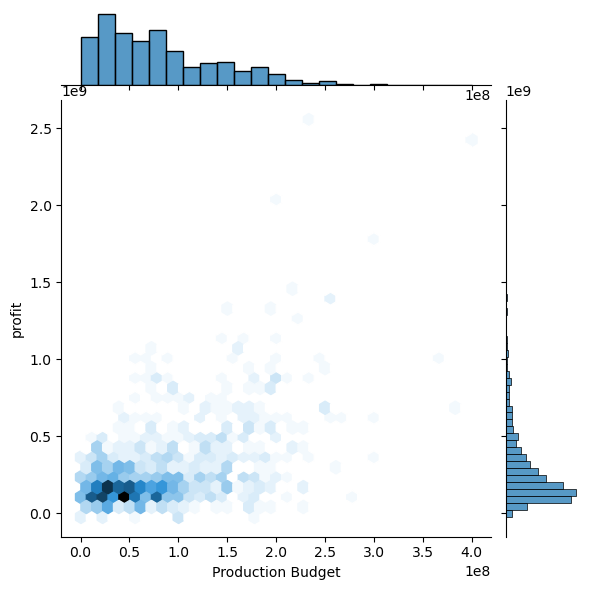

In [153]:
sns.jointplot(data=movie_feature_with_budget, x='Production Budget', y='profit', kind="hex");


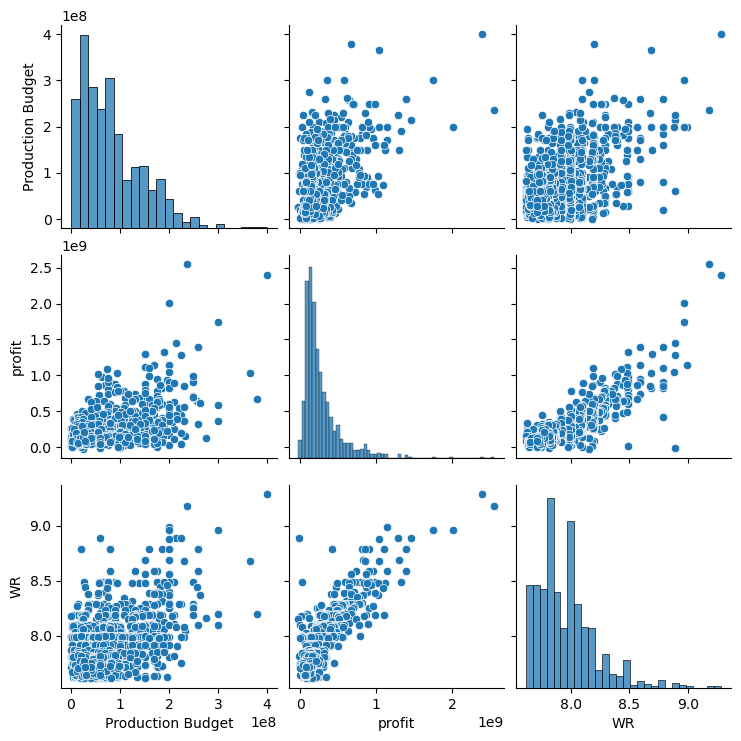

In [154]:
sns.pairplot(movie_feature_with_budget[['Production Budget','profit','WR']])

In [155]:
Top20_ProfitableMovies = movie_feature_with_budget.sort_values('profit', ascending=False).head(20)

Profit margin 

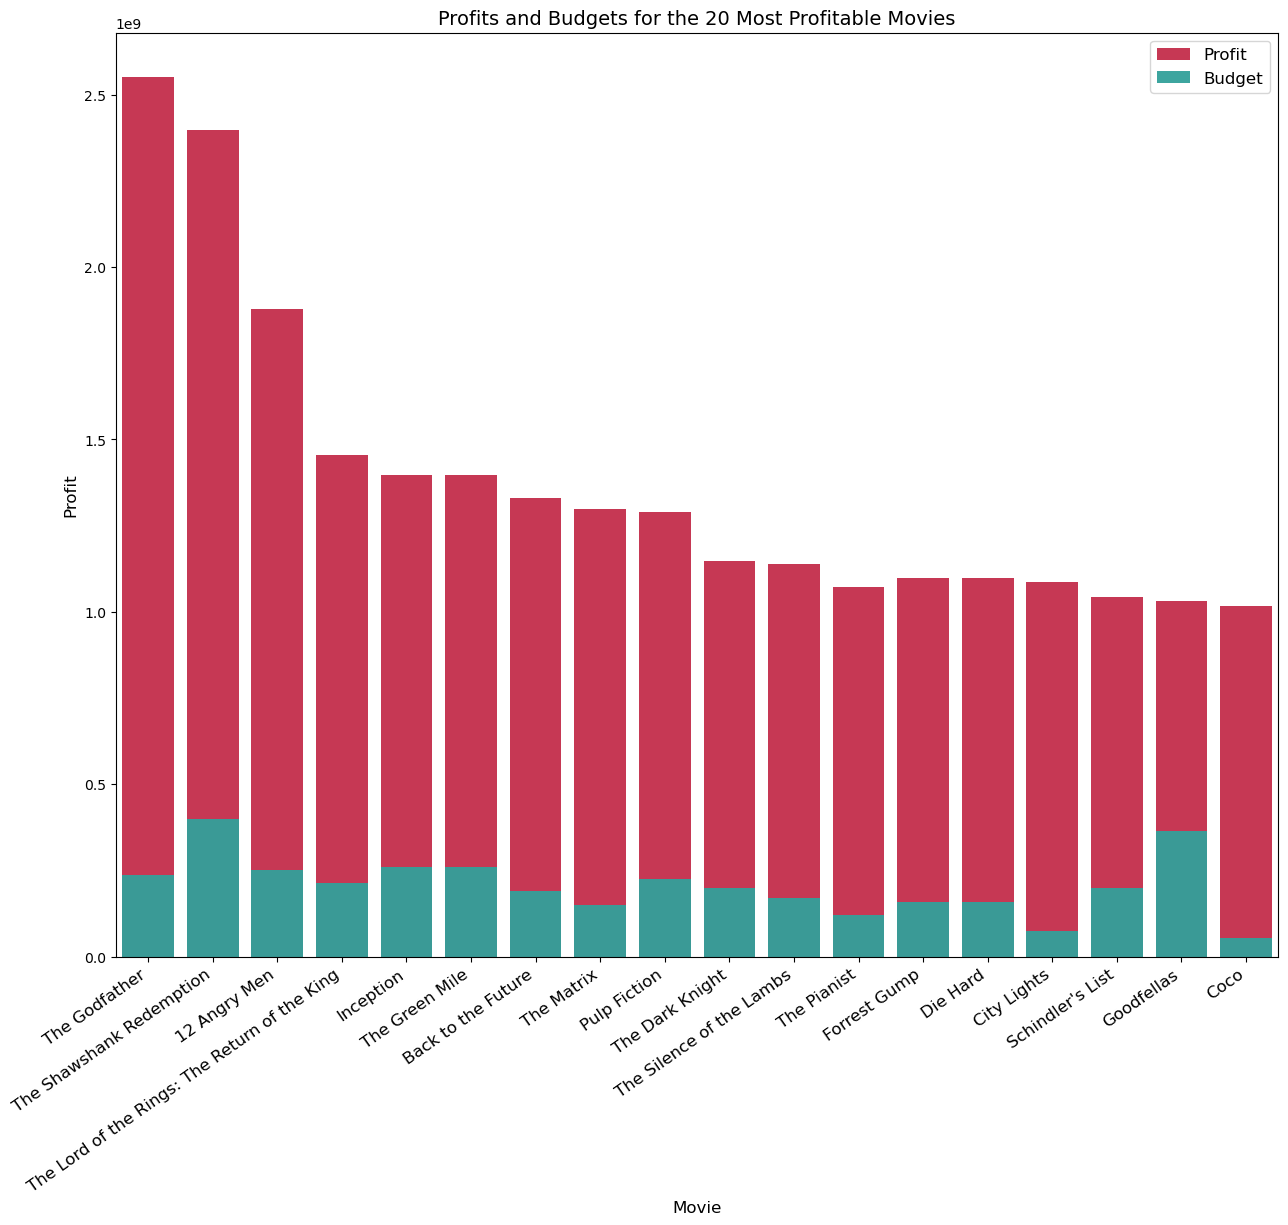

In [156]:
plt.figure(figsize=(15,12))
sns.barplot(x=Top20_ProfitableMovies['Series_Title'],y=Top20_ProfitableMovies['profit'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Series_Title'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=12)
plt.legend(fontsize=12)

## Impact of director

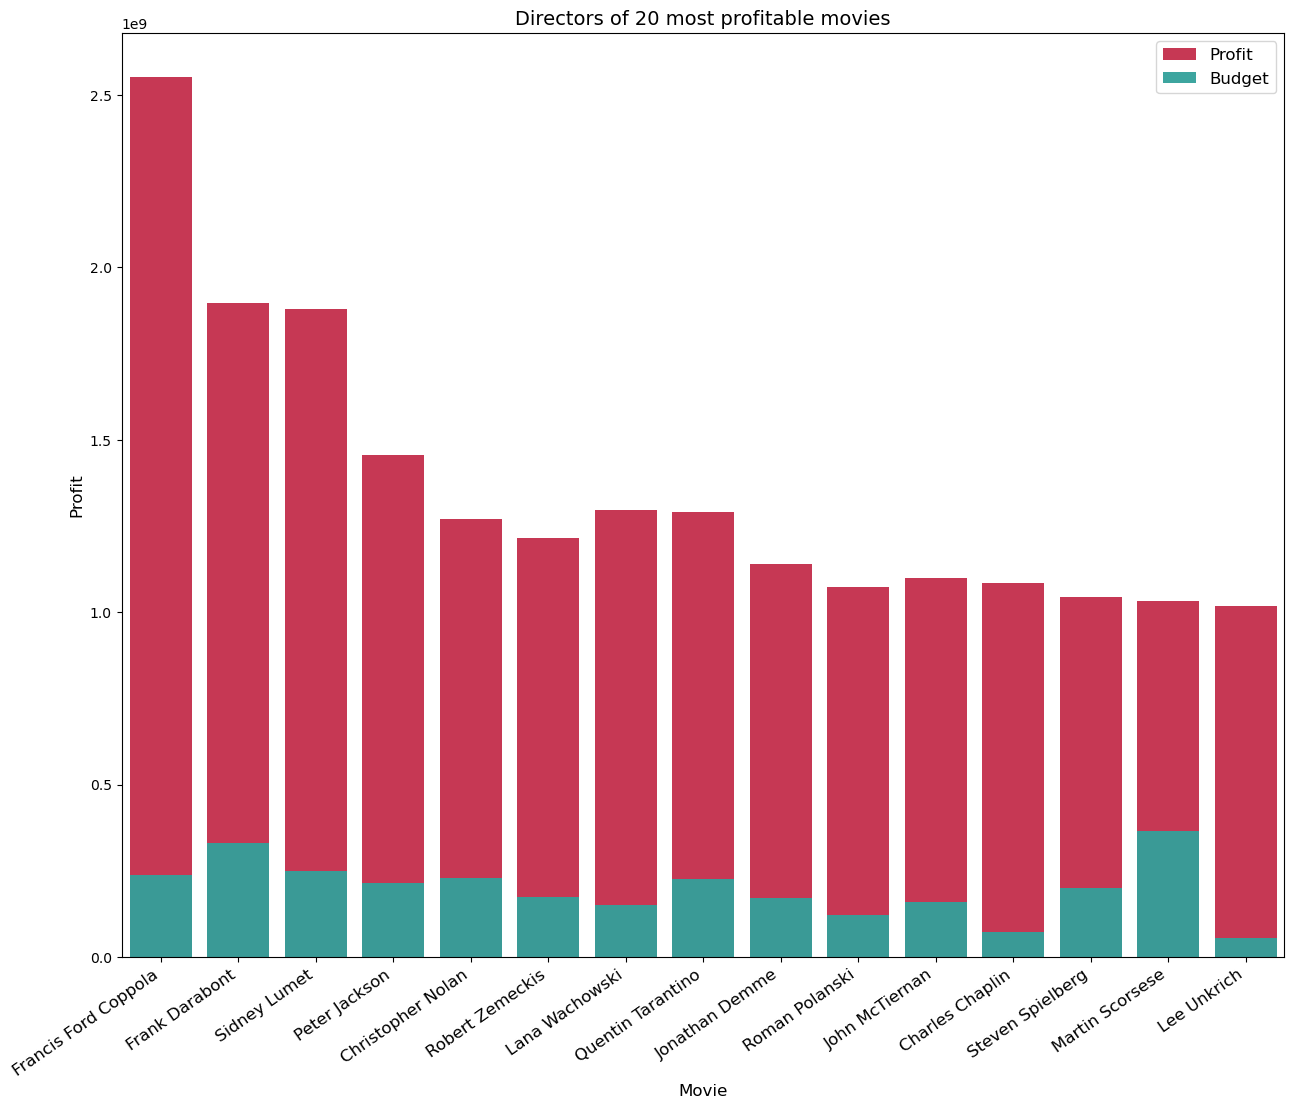

In [157]:
plt.figure(figsize=(15,12))
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['profit'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Directors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=12)
plt.legend(fontsize=12)

## Impact of actors

HOW TO ACCOUNT FOR DIFFERENT ACTORS ??? only Star1

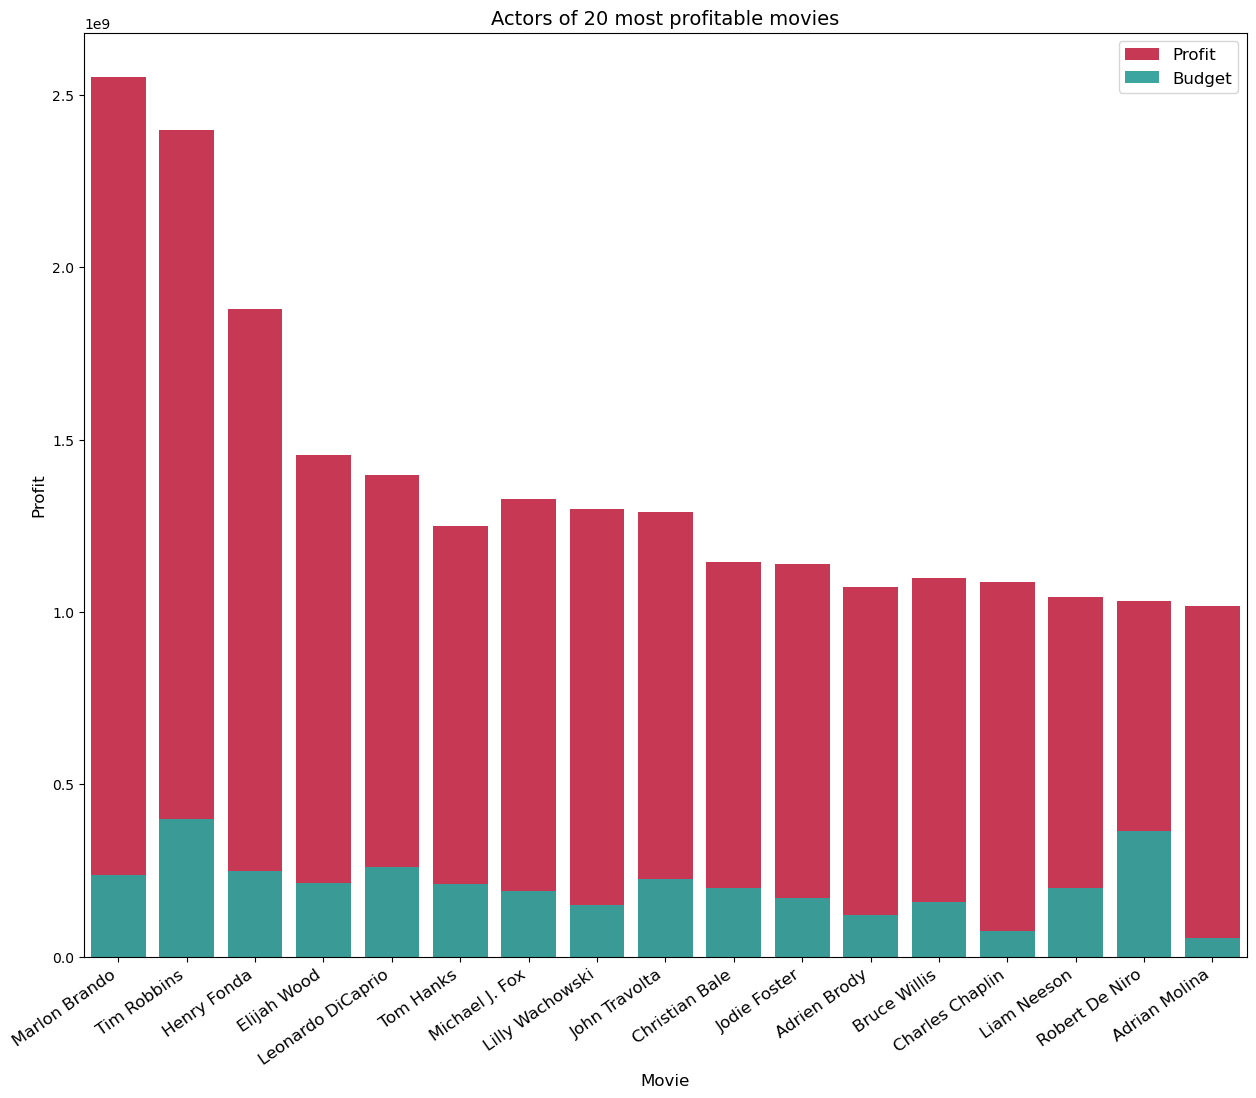

In [158]:
plt.figure(figsize=(15,12))
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Actors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=12)
plt.legend(fontsize=12)

## Popular features in characters

Characters dataset splitted in males and females to easily compare among genders

In [159]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

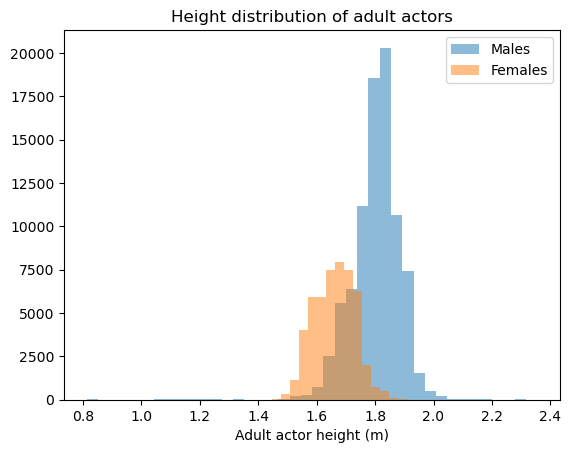

In [160]:
def characters_height_histogram(characters, bins):
    LIMIT_CHILDREN_AGE = 14
    characters_height = characters.dropna(subset=['actor_height_meters'])
    characters_height = characters_height[(characters_height['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(characters_male, bins=40)
characters_height_histogram(characters_female, bins=25)

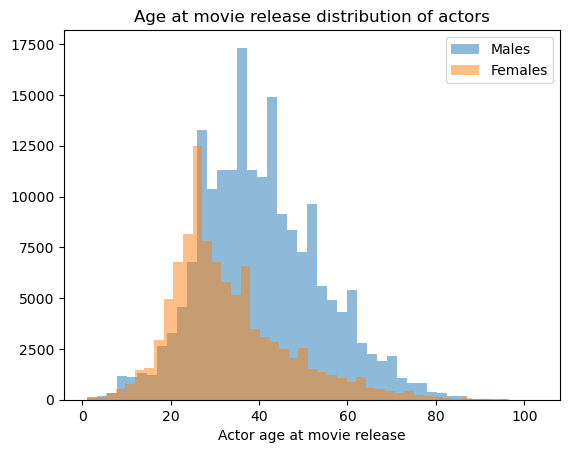

In [161]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

## What genres are the most profitable?

In [162]:
movie_feature_with_budget['profit'] = movie_feature_with_budget['Worldwide Gross'] - movie_feature_with_budget['Production Budget']

<AxesSubplot:title={'center':'Movie profit distribution'}, ylabel='Frequency'>

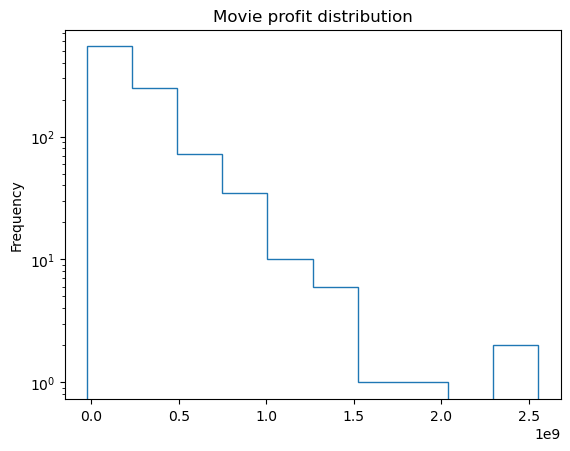

In [163]:
movie_feature_with_budget['profit'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution')

In [164]:
movie_feature_with_budget['genre1'] = movie_feature_with_budget['genres'].apply(lambda el: el[0])

<AxesSubplot:title={'center':'Movie genres distribution'}>

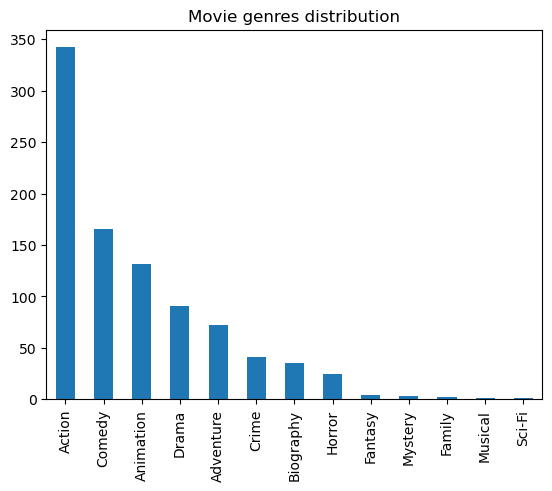

In [165]:
movie_feature_with_budget['genre1'].value_counts().plot(kind='bar', title='Movie genres distribution')

In [166]:
def visualize_genres_profit(genres, means, p025s, p975s, axis, title):
    axis.errorbar(
        np.arange(len(genres)),
        means,
        xerr=0.5,
        yerr=[means - p025s, p975s - means],
        linestyle='', alpha=0.7, color='teal'
    )

    axis.set_title(title)
    print(genres)
    ax.set_xticks(np.arange(len(genres)))
    axis.xaxis.set_major_locator(plt.FixedLocator(np.arange(len(genres))))
    axis.set_xticklabels(genres, rotation=90)


In [167]:
def calculate_average_difference_95_ci(data):
    average_difference = np.mean(data)
    ci_95 = np.percentile(data, [2.5, 97.5])

    return average_difference, ci_95

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Musical', 'Mystery', 'Sci-Fi'],
      dtype='object', name='genre1')


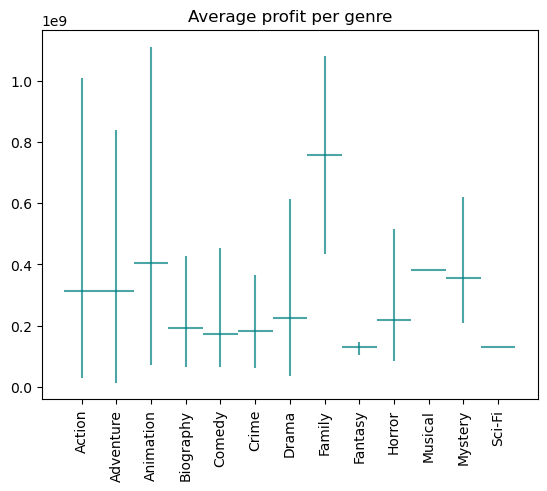

In [168]:
profit = movie_feature_with_budget.groupby('genre1').agg({'profit': calculate_average_difference_95_ci})['profit']

profit_mean = profit.str[0]
profit_p025 = profit.str[1].str[0]
profit_p975 = profit.str[1].str[1]

figure, axis = plt.subplots(1, 1)
visualize_genres_profit(profit_mean.index, profit_mean, profit_p025, profit_p975, axis, 'Average profit per genre')

## correlation between the choice of topics and movie profitability can be investigated

In [174]:
movie_feature_with_budget['genre1_category'] = movie_feature_with_budget['genre1'].astype('category').cat.codes

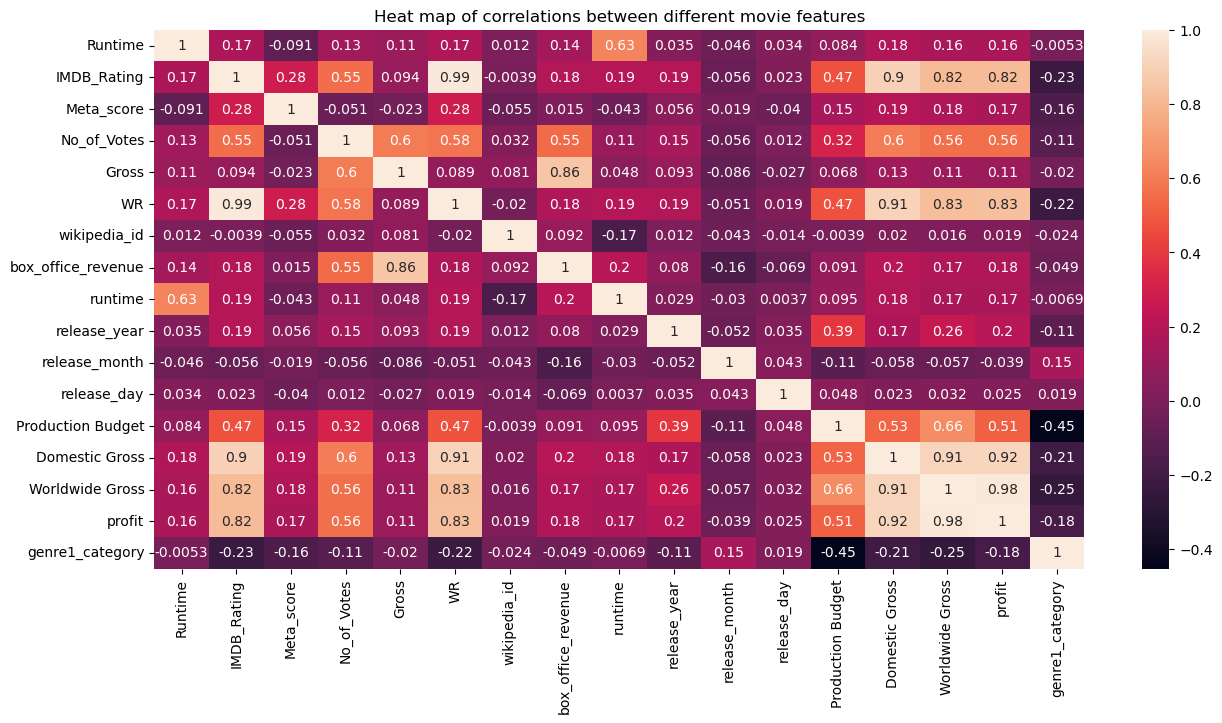

In [176]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(movie_feature_with_budget.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

## Clustering between movies: Classics VS forgettable : check with wikipedia ID how much it is visited : time series of access 

In [191]:
wikipedia_pageviews.sample(5)

,movie_name,date,pageviews
1360717,Spy Kids,2022-01-15,985
1362875,Face/Off,2020-07-27,5108
177096,The Hobbit: An Unexpected Journey,2021-10-01,1330
134670,Guardians of the Galaxy,2019-01-18,370
537067,The Revenant,2021-09-16,34


<AxesSubplot:title={'center':'Pageviews for Spy Kids'}, xlabel='date'>

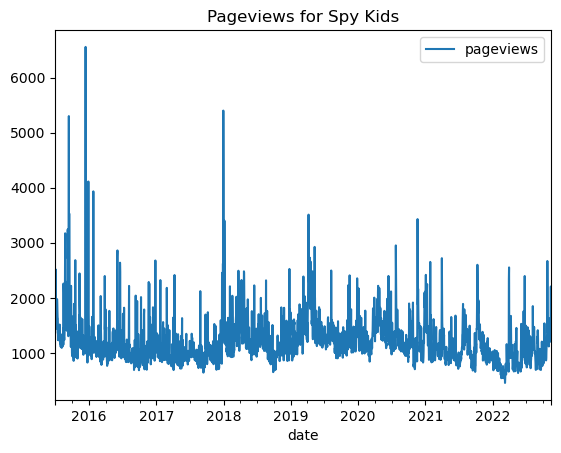

In [192]:
wikipedia_pageviews[wikipedia_pageviews['movie_name'] == 'Spy Kids'].plot(x='date', y='pageviews', title='Pageviews for Spy Kids')

<AxesSubplot:title={'center':'Pageviews for Avengers: Endgame'}, xlabel='date'>

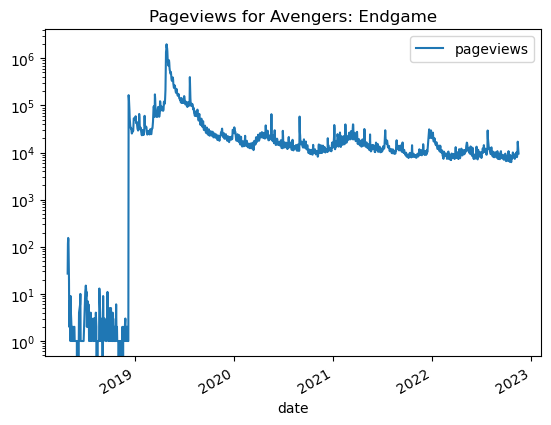

In [195]:
wikipedia_pageviews[wikipedia_pageviews['movie_name'] == 'Avengers: Endgame'].plot(x='date', y='pageviews', logy=True, title='Pageviews for Avengers: Endgame')

In [207]:
movie_feature_with_budget_and_wikipedia_pageviews.sample(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,release_year,release_month,release_day,Production Budget,Domestic Gross,Worldwide Gross,profit,genre1,genre1_category,pageviews
914,https://m.media-amazon.com/images/M/MV5BMTY5OD...,The 39 Steps,1935,NaN,86,"Crime, Mystery, Thriller",7.6,A man in London tries to help a counter-espion...,93.0,Alfred Hitchcock,...,2001,4,6,28000000,74058698,105159085,77159085,Drama,6,60.267213
431,https://m.media-amazon.com/images/M/MV5BM2JkNG...,The Bourne Identity,2002,UA,119,"Action, Mystery, Thriller",7.9,"A man is picked up by a fishing boat, bullet-r...",68.0,Doug Liman,...,1994,5,27,45000000,130531208,358500000,313500000,Comedy,4,2009.825603
740,https://m.media-amazon.com/images/M/MV5BMTgxMD...,Barton Fink,1991,U,116,"Comedy, Drama, Thriller",7.7,A renowned New York playwright is enticed to C...,69.0,Joel Coen,...,1953,2,5,100000000,48417850,95255485,-4744515,Animation,2,2639.497217
14,https://m.media-amazon.com/images/M/MV5BNWIwOD...,Forrest Gump,1994,UA,142,"Drama, Romance",8.8,"The presidencies of Kennedy and Johnson, the e...",82.0,Robert Zemeckis,...,2017,3,16,20000000,206333165,438707031,418707031,Family,7,1718.977737
308,https://m.media-amazon.com/images/M/MV5BMjA2Mz...,Vizontele,2001,NaN,110,"Comedy, Drama",8.0,Lives of residents in a small Anatolian villag...,NaN,Yilmaz Erdogan,...,2019,1,3,129000000,160799505,522189138,393189138,Animation,2,3747.564516


In [212]:
movie_feature_with_budget_and_wikipedia_pageviews.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day', 'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'profit', 'genre1', 'genre1_category', 'pageviews'],
      dtype='object')

In [218]:
movie_feature_with_budget_and_wikipedia_pageviews['release_year'] = movie_feature_with_budget_and_wikipedia_pageviews['release_year'].astype(int)

In [219]:
mod = smf.ols(formula='pageviews ~ release_year + runtime + WR + Director + Star1 + Star2 + Star3 + Star4 + Gross + profit + genre1', data=movie_feature_with_budget_and_wikipedia_pageviews[movie_feature_with_budget_and_wikipedia_pageviews['release_year'] < (2015-15)])
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1.094
Date:                Thu, 17 Nov 2022   Prob (F-statistic):              0.441
Time:                        13:27:03   Log-Likelihood:                -1388.3
No. Observations:                 183   AIC:                             3109.
Df Residuals:                      17   BIC:                             3641.
Df Model:                         165                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            5400.9336   5168.888      1.045      0.311   -5504.467    1.63e+04
Director[T.Akira Kurosawa]             -0.0069      0.007     -0.974      0.344      -0.022       0.008
Director[T.Alan J. Pakula]            211.3147    363.978      0.581      0.569    -556.612     979.241
Director[T.Alan Parker]               326.5735    505.222      0.646      0.527    -739.352    1392.499
Director[T.Alejandro Amenábar]        537.2749    650.064      0.826      0.420    -834.241    1908.791
Director[T.Alejandro G. Iñárritu]      22.9349    940.982      0.024      0.981   -1962.364    2008.234
Director[T.Alex Proyas]               421.8726   1259.890      0.335      0.742   -2236.262    3080.008
Director[T.Alfonso Cuarón]            809.3567    570.496      1.419      0.174    -394.284    2012.997
Director[T.Alfred Hitchcock]        -2056.9966   1227.433     -1.676      0.112   -4646.653     532.660
Director[T.Andrei Tarkovsky]         -564.9331   1203.143     -0.470      0.645   -3103.342    1973.476
Director[T.Andrew Davis]             1485.0150    830.030      1.789      0.091    -266.195    3236.225
Director[T.Andrew Niccol]            1074.5080    953.904      1.126      0.276    -938.054    3087.070
Director[T.Andrew Stanton]           -769.2128    765.463     -1.005      0.329   -2384.199     845.773
Director[T.Ang Lee]                  1087.4601    967.658      1.124      0.277    -954.119    3129.039
Director[T.Anton Corbijn]             413.0087    635.176      0.650      0.524    -927.095    1753.113
Director[T.Anurag Kashyap]             -0.0002      0.000     -0.519      0.610      -0.001       0.001
Director[T.Barry Levinson]            816.6964    890.141      0.917      0.372   -1061.336    2694.729
Director[T.Ben Affleck]               516.1166   1121.848      0.460      0.651   -1850.777    2883.010
Director[T.Bennett Miller]            870.2233    910.568      0.956      0.353   -1050.907    2791.353
Director[T.Billy Wilder]             2.831e-05   1.65e-05      1.719      0.104   -6.45e-06    6.31e-05
Director[T.Bob Fosse]                -670.3907    567.285     -1.182      0.254   -1867.258     526.476
Director[T.Brad Anderson]            1023.2282   1407.152      0.727      0.477   -1945.603    3992.060
Director[T.Brad Bird]                -221.8254    429.709     -0.516      0.612   -1128.432     684.782
Director[T.Bradley Cooper]          -1.211e-05   7.08e-06     -1.710      0.106   -2.71e-05    2.83e-06
Director[T.Brian De Palma]             37.9410    488.746      0.078      0.939    -993.223    1069.105
Director[T.Carol Reed]               -405.7944    722.174     -0.562      0.582   -1929.448    1117.859
Director[T.Charles Chaplin]         -1722.2226   1758.292     -0.97